Mettre en range les graphes
warning pour MI ?

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 1 # manualy take the first GPU

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 1


In [3]:
#!pip install -q keract 
import numpy
from keract import get_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import tensorflow as tf
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Loading models

In [5]:
# LOAD MODELS
#model A: sans regularization
modelA = load_model('models/modelA.h5')
modelA.load_weights('models/modelA_weights_epoch50.h5')
#model A: avec regularisation
modelB = load_model('models/modelB.h5')
modelB.load_weights('models/modelB_weights_epoch50.h5')

In [6]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("Model 1 CNN Error: %.2f%%" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("Model B CNN Error: %.2f%%" % (100-scoresB[1]*100))

10000/10000 [==============================] - 2s 236us/step
Test loss: 2.3422891954422
Test accuracy: 0.6146
Model 1 CNN Error: 38.54%
10000/10000 [==============================] - 1s 129us/step
Test loss: 0.7456463940620423
Test accuracy: 0.7555
Model B CNN Error: 24.45%


### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [7]:
# On regarde l'activation des neurones pour un echantillon test
Echantillon = []
nombreDImagesDActivation = 20
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMA = get_activations(modelA, Echantillon)
IMB = get_activations(modelB, Echantillon)

In [8]:
# on affiche les noms des differentes couches
print(IMA.keys())
print(IMB.keys())

dict_keys(['dense_2/Softmax:0', 'conv2d_2/Relu:0', 'flatten_1/Reshape:0', 'conv2d_1/Relu:0', 'conv2d_3/Relu:0', 'max_pooling2d_2/MaxPool:0', 'dense_1/Relu:0', 'conv2d_4/Relu:0', 'max_pooling2d_1/MaxPool:0'])
dict_keys(['conv2d_5/Relu:0', 'max_pooling2d_3/MaxPool:0', 'conv2d_8/Relu:0', 'conv2d_6/Relu:0', 'dense_3/Relu:0', 'conv2d_7/Relu:0', 'dropout_3/cond/Merge:0', 'flatten_2/Reshape:0', 'max_pooling2d_4/MaxPool:0', 'dropout_2/cond/Merge:0', 'dropout_1/cond/Merge:0', 'dense_4/Softmax:0'])


In [9]:
def MI(IMA, nameOfTheLayer):
    #nombre d'images utilisées pour l'activation:
    numActivations = len(IMA[nameOfTheLayer])
    
    #nombre de neurones dans la couche
    #numNeurons = len(IMA[nameOfTheLayer][0])
    numNeurons = numpy.size(IMA[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM0[nameOfTheLayer])
    #plt.imshow(IM0[nameOfTheLayer])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NombrePairs = 1000
    print('number of pairs of neurons analyzed: '+str(NombrePairs))

    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IMA[nameOfTheLayer]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)
            #print(numpy.size(activation))
            activation = activation.flatten()
            #print(activation)
            X[i] = activation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = activation[int(NeuronsSelected[j][1])-1]

            # On binarise : RELU
            if X[i] > 0:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > 0:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        #print(X)
        #print(Y)

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y)
        #print(MutualInfo[j])

    return MutualInfo

number of images used for see the activations : 20


 Model A :

couche : conv2d_1/Relu:0
number of neurons for the layer: 32768
number of pairs of neurons analyzed: 1000
couche : conv2d_2/Relu:0
number of neurons for the layer: 28800
number of pairs of neurons analyzed: 1000
couche : max_pooling2d_1/MaxPool:0
number of neurons for the layer: 7200
number of pairs of neurons analyzed: 1000
couche : conv2d_3/Relu:0
number of neurons for the layer: 14400
number of pairs of neurons analyzed: 1000
couche : conv2d_4/Relu:0
number of neurons for the layer: 10816
number of pairs of neurons analyzed: 1000
couche : max_pooling2d_2/MaxPool:0
number of neurons for the layer: 2304
number of pairs of neurons analyzed: 1000
couche : flatten_1/Reshape:0
number of neurons for the layer: 2304
number of pairs of neurons analyzed: 1000
couche : dense_1/Relu:0
number of neurons for the layer: 512
number of pairs of neurons analyzed: 1000
couche : dense_2/Softmax:0
number of neurons for the layer: 10
number

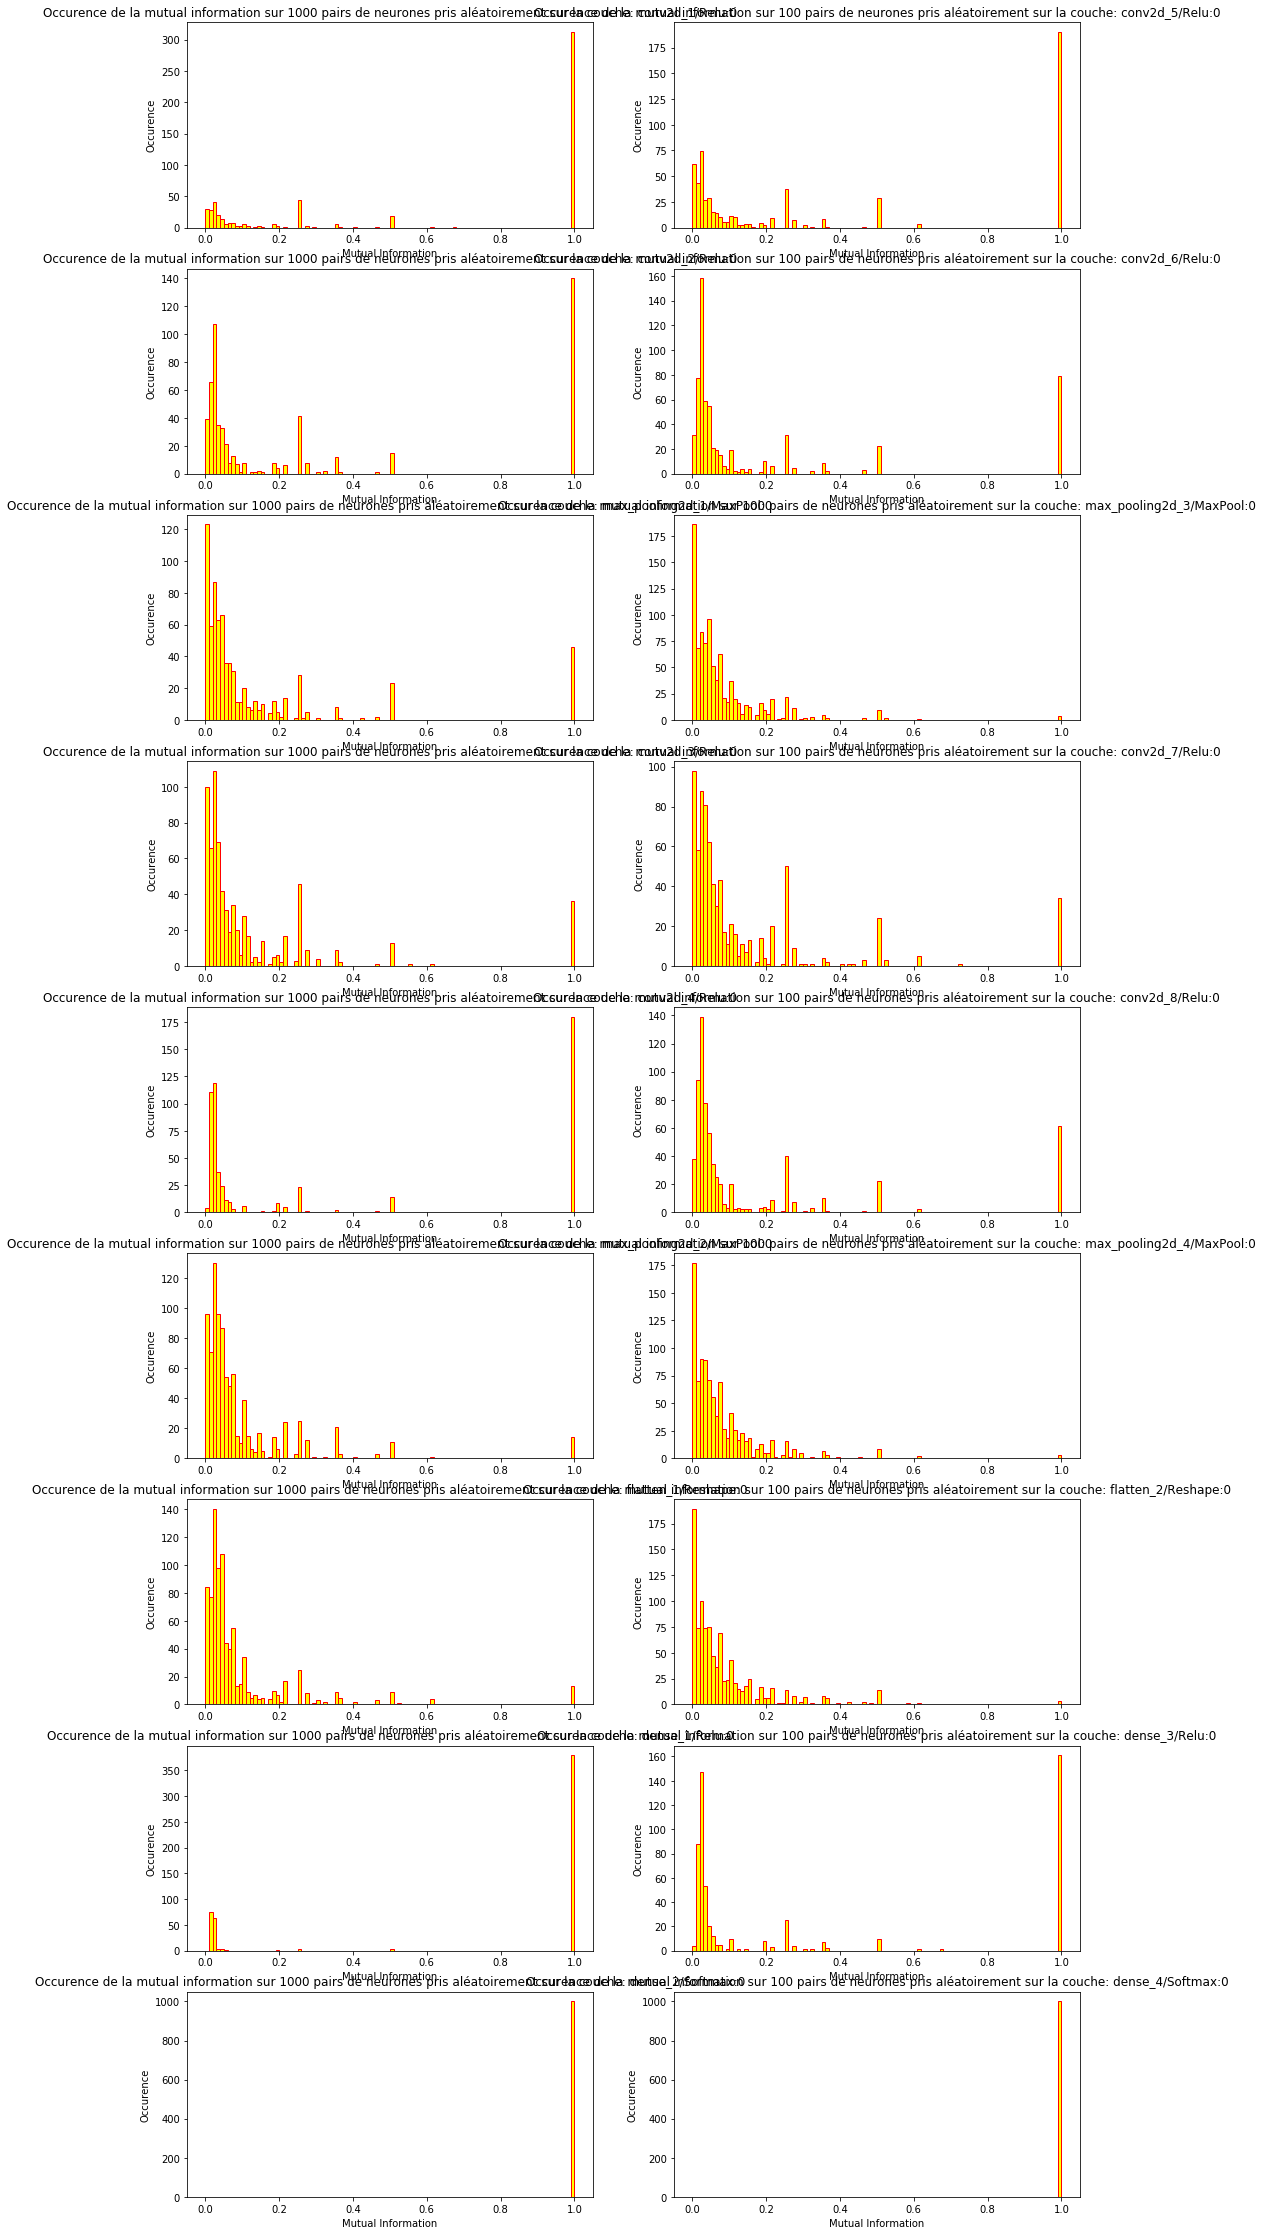

In [12]:
print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')

fig = plt.figure(figsize=(16, 40))
plt.ylim(top=1000)

List_of_Layers_A = ['conv2d_1/Relu:0', 'conv2d_2/Relu:0','max_pooling2d_1/MaxPool:0', 'conv2d_3/Relu:0', 'conv2d_4/Relu:0', 'max_pooling2d_2/MaxPool:0', 'flatten_1/Reshape:0', 'dense_1/Relu:0', 'dense_2/Softmax:0']
List_of_Layers_B = ['conv2d_5/Relu:0', 'conv2d_6/Relu:0','max_pooling2d_3/MaxPool:0', 'conv2d_7/Relu:0', 'conv2d_8/Relu:0', 'max_pooling2d_4/MaxPool:0', 'flatten_2/Reshape:0', 'dense_3/Relu:0', 'dense_4/Softmax:0']


# model A a gauche
print('\n Model A :\n')
i = 1
for layer in List_of_Layers_A:
    #nom de la couche
    print('couche :', str(layer))
    #MI
    MutualInfo = MI(IMA, layer)
    #plot
    plt.subplot(len(IMA), 2, i)
    plt.hist(MutualInfo, range = (0, 1), bins = 100, color = 'yellow',
            edgecolor = 'red')
    plt.xlabel('Mutual Information')
    plt.ylabel('Occurence')
    plt.title('Occurence de la mutual information sur 1000 pairs de neurones pris aléatoirement sur la couche: '+ str(layer))
    i = i + 2

# model B a droite
print('\n Model B :\n')
i = 2
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        #MI
        MutualInfo = MI(IMB, layer)
        #plot
        plt.subplot(len(IMA), 2, i)
        plt.hist(MutualInfo, range = (0, 1), bins = 100, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information')
        plt.ylabel('Occurence')
        plt.title('Occurence de la mutual information sur 100 pairs de neurones pris aléatoirement sur la couche: '+ str(layer))
        i = i + 2
plt.show()